# Spatial plot with custom color

In [2]:
import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import sys, os
import anndata as ad
import squidpy as sq

other_dir_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(other_dir_path)

import IMCprocess.spatial_analysis.spatial_analysis as sa
import IMCprocess.spatial_analysis.combi_enrich as ce
import IMCprocess.utils.utils as ut

# I have to use custom Img_anndata code
import Img_anndata as ia
import IMCprocess.utils.utils as ut

## Import object for plotting and merge label for level2 in level1 object

In [3]:
data_path = '/Users/pattama/Desktop/UiB/cancer/example_share_code/share_with_vladan/mask_analysis_full_pipeline/example_data/'
data_lev1 = ut.read_pickle_obj(data_path+'00hanna_adata_totalNB_obj_Level1.pkl')
Ep_lev2 = ut.read_pickle_obj(data_path+'02hanna_adata_totalNB_obj_EpLevel2.pkl')
Im_lev2 = ut.read_pickle_obj(data_path+'02hanna_adata_totalNB_obj_ImmuneLevel2.pkl')
Fi_lev2 = ut.read_pickle_obj(data_path+'02hanna_adata_totalNB_obj_Level2.pkl')

In [4]:
# get anndata for level1, epithelial level2, immune level2, fibroblast level2
level1_adata = data_lev1.adata_dict['level1']
Ep_adata = Ep_lev2.adata_dict['Ep_level2']
Im_adata = Im_lev2.adata_dict['Immune_level2']
Fi_adata = Fi_lev2.adata_dict['Fibro_level2']

In [5]:
def add_level2_to_level1_obs(level1_adata, level2_adata_list):
    '''
    Add level2 annotation to level1 adata object
    '''
    level1_adata.obs['level2'] = level1_adata.obs['level1_annotated'].astype(str)
    for lev2_adata in level2_adata_list:
        lev2_col = lev2_adata.obs.columns[lev2_adata.obs.columns.str.contains('level2')][0]
        lev2_adata.obs['level2'] = lev2_adata.obs[
            'level1_annotated'].astype('str') + '_' + lev2_adata.obs[lev2_col].astype('str')
        level1_adata.obs.loc[lev2_adata.obs.level2.index, 'level2'] = lev2_adata.obs.level2
    return level1_adata

In [6]:
add_level2_to_level1_obs(level1_adata=level1_adata, level2_adata_list=[Ep_adata, Im_adata, Fi_adata])

AnnData object with n_obs × n_vars = 132951 × 51
    obs: 'img_id', 'PhenoGraph_clusters', 'level1_annotated', 'level2'
    uns: 'pca', 'PhenoGraph_Q', 'PhenoGraph_k', 'neighbors', 'umap', 'PCs', 'dendrogram_PhenoGraph_clusters', 'PhenoGraph_clusters_colors', 'level1_annotated_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [7]:
# Update level1_adata with leve2 label to data_lev1
data_lev1.adata_dict['level1'] = level1_adata

In [13]:
# check cell type level1
level1_adata.obs['level1_annotated'].value_counts()

Ep        64874
Immune    29445
Fibro     17129
Undef     10224
Ves        6452
Amb        4827
Name: level1_annotated, dtype: int64

In [12]:
# Check cell type names
level1_adata.obs.level2.value_counts()

Ep_Ca_nonstem                               63378
Immune_Undef                                12153
Undef                                       10224
Ves                                          6452
Immune_CD8                                   5743
Amb                                          4827
Immune_CD4                                   4119
Fibro_aSMA+_FAPlow_PDGFRalow_PDGFRblow       2901
Immune_CD8_CD4_FoxP3                         2693
Immune_CD4_FoxP3                             2660
Fibro_aSMA+_FAP+_PDGFRalow_PDGFRblow         2419
Fibro_PDGFRalow_PDGFRblow                    1995
Fibro_FAP+_PDGFRalow                         1856
Ep_Ca_stem                                   1496
Fibro_FAPlow_PDGFRalow_PDGFRblow             1358
Fibro_aSMAlow_FAPlow_PDGFRalow_PDGFRblow     1281
Fibro_Neg                                    1188
Fibro_aSMAlow_PDGFRalow_PDGFRblow            1054
Immune_CD4_ki67                              1042
Immune_CD8_ki67                              1035


In [19]:
level1_adata.obs.head()

,img_id,PhenoGraph_clusters,level1_annotated,level2
Cell_id,,,,
1_0,R1_001,45,Ep,Ep_Ca_nonstem
2_0,R1_001,12,Immune,Immune_CD8
3_0,R1_001,34,Ves,Ves
4_0,R1_001,0,Fibro,Fibro_aSMA+_FAPlow_PDGFRalow_PDGFRblow
5_0,R1_001,45,Ep,Ep_Ca_nonstem


## Choose custom list of cell types and colors for spatial plot
You can check list of color name in this link 
https://matplotlib.org/stable/gallery/color/named_colors.html

In [30]:
def plt_spatial(adata, marker, output_path,name):
      fig = sc.pl.spatial(adata, color=marker,    
                          title=[name+' '+marker],
                          return_fig=True,
                          spot_size=10, show = False)
      fig2 = fig[0].get_figure()
      fig2.tight_layout()
      fig2.savefig(output_path+marker+'_'+name+'_spatial.png', dpi = 300)

In [31]:
def plt_spatial_cell_list(adata, cell_list, color_list, obs_col, output_path, img_id, name):
    filtered_adata = adata[adata.obs[obs_col].isin(cell_list)]
    img_adata = filtered_adata[filtered_adata.obs['img_id'] == img_id]
    img_adata.uns[obs_col+'_colors'] = color_list
    plt_spatial(img_adata,obs_col, output_path, name+'_'+img_id)

In [32]:
# Provide input list of cell names for spatial plot and color list
Cell_list = ['Ep_Ca_nonstem', 'Fibro_PDGFRa+', 'Fibro_FAP+_PDGFRalow']
color_list = ['navy', 'brown', 'green']

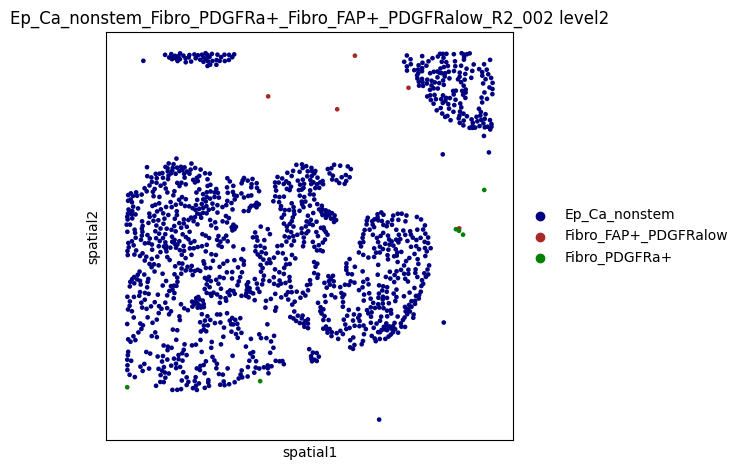

In [33]:
plt_spatial_cell_list(level1_adata, 
                      Cell_list, 
                      color_list,
                      'level2', 
                      '02output/', 
                      'R2_002', 
                      ('_').join(Cell_list))